## Preprocessing Network Data
This Notebook explains the preprocessing of network based tabular data by example of the CIDDS-001 dataset. Original dataset and context can be found under [link](https://www.hs-coburg.de/forschung/forschungsprojekte-oeffentlich/informationstechnologie/cidds-coburg-intrusion-detection-data-sets.html)

In [ ]:
#download dataset from website
import wget
url = 'https://www.hs-coburg.de/fileadmin/hscoburg/WISENT-CIDDS-001.zip'
wget.download(url, out='data/')

#extract files from zip
import zipfile
with zipfile.ZipFile("data/WISENT-CIDDS-001.zip","r") as zip_ref:
    zip_ref.extractall("data/")

Under the directory `data/WISENT-CIDDS-001/` you can find all the data generated by the researchers and the Technical report pdf explains how these datasets are generated. We choose to load in week one of network traffic data. This contains the most number of attacks. 

In [1]:
import pandas as pd
df = pd.read_csv("data/CIDDS-001/traffic/OpenStack/CIDDS-001-internal-week1.csv",
                low_memory=False)
df.head()

,Date first seen,Duration,Proto,Src IP Addr,Src Pt,Dst IP Addr,Dst Pt,Packets,Bytes,Flows,Flags,Tos,class,attackType,attackID,attackDescription
0,2017-03-15 00:01:16.632,0.000,TCP,192.168.100.5,445,192.168.220.16,58844.0,1,108,1,.AP...,0,normal,---,---,---
1,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,445,192.168.220.15,48888.0,1,108,1,.AP...,0,normal,---,---,---
2,2017-03-15 00:01:16.551,0.004,TCP,192.168.220.15,48888,192.168.100.5,445.0,2,174,1,.AP...,0,normal,---,---,---
3,2017-03-15 00:01:16.631,0.004,TCP,192.168.220.16,58844,192.168.100.5,445.0,2,174,1,.AP...,0,normal,---,---,---
4,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,445,192.168.220.15,48888.0,1,108,1,.AP...,0,normal,---,---,---


In [2]:
df = df.sort_values('Date first seen', ascending=True)
df = df.drop_duplicates()

<AxesSubplot: ylabel='attackType'>

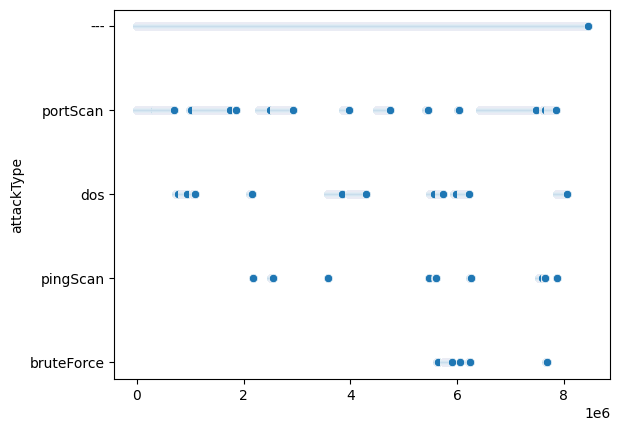

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x=df.index, y=df['attackType'])

The amount of normal traffic, denoted by `--` is quite large. We can reduce the percentage of normal traffic for faster computing and removing redundant rows.

We display the number of rows of each class before and after removing normal traffic.

In [4]:
import numpy as np

def drop_percentage(df,label_value, perc=0.8):
    temp = df[df['attackType']==label_value]
    remove_n = int(len(temp)*perc)
    drop_indices = np.random.choice(temp.index, remove_n, replace=False)
    df_subset = df.drop(drop_indices)
    return df_subset

df_subset = drop_percentage(df, '---')

display(df['attackType'].value_counts())
display(df_subset['attackType'].value_counts())
del df
df = df_subset
del df_subset

---           7010112
dos           1055854
portScan       177082
pingScan         3358
bruteForce       1623
Name: attackType, dtype: int64

---           1402023
dos           1055854
portScan       177082
pingScan         3358
bruteForce       1623
Name: attackType, dtype: int64

The algorithm expects the labels to be one-hot encoded. We also change name of normal traffic to `benign`. 

In [5]:
#preprocess the labels
df['attackType'].replace('---', 'benign', inplace=True)
df = pd.get_dummies(df, prefix='attack', columns=['attackType'])
df.head()

,Date first seen,Duration,Proto,Src IP Addr,Src Pt,Dst IP Addr,Dst Pt,Packets,Bytes,Flows,Flags,Tos,class,attackID,attackDescription,attack_benign,attack_bruteForce,attack_dos,attack_pingScan,attack_portScan
2,2017-03-15 00:01:16.551,0.004,TCP,192.168.220.15,48888,192.168.100.5,445.0,2,174,1,.AP...,0,normal,---,---,1,0,0,0,0
23,2017-03-15 00:01:17.728,0.047,TCP,192.168.220.16,45586,10000_35,443.0,5,906,1,.AP.S.,0,normal,---,---,1,0,0,0,0
38,2017-03-15 00:01:18.664,0.111,TCP,192.168.220.16,55975,10002_114,443.0,3,1815,1,.AP...,0,normal,---,---,1,0,0,0,0
34,2017-03-15 00:01:18.665,0.000,UDP,DNS,53,192.168.220.16,56225.0,2,533,1,......,0,normal,---,---,1,0,0,0,0
33,2017-03-15 00:01:18.769,0.000,UDP,DNS,53,192.168.220.16,35549.0,1,224,1,......,0,normal,---,---,1,0,0,0,0


Columns containing categorical information such as protocol, source & destination port and flags (syn, ack, push, ...) can be encoded. We choose to remove the port numbers since there are too many unique values to encode. 

In [6]:
col_cat= ['Proto', 'Src Pt', 'Dst Pt','Flags', 'Tos']
for col in col_cat:
    display(df[col].value_counts())

TCP      2419742
UDP       210288
ICMP        9865
IGMP          45
Name: Proto, dtype: int64

80       773951
443      298374
53        98779
445       29474
8082      11208
          ...  
65308         1
61090         1
64361         1
62658         1
64803         1
Name: Src Pt, Length: 33656, dtype: int64

80.0       782712
443.0      303782
53.0        98590
445.0       29315
8082.0      11234
            ...  
63571.0         1
61736.0         1
61788.0         1
64906.0         1
61087.0         1
Name: Dst Pt, Length: 33658, dtype: int64

.AP.SF    573562
.A....    531117
.A..SF    526678
......    220198
.AP...    209596
.AP.S.    170630
.A...F    123305
....S.    103987
.A.R..     63598
.AP..F     51210
.A..S.     42538
...R..      9380
.APR.F      5901
...RS.      3143
.A.R.F      1976
.APR..      1173
.APRSF       982
.APRS.       755
.A.RS.       154
.A.RSF        57
Name: Flags, dtype: int64

0      2161449
32      475397
192       2901
16         193
Name: Tos, dtype: int64

In [7]:
def convert_flags(val):
    flag_string = '.APRSF'
    result = []
    for x, y in zip(flag_string[1:], val[1:]):
        if x==y:
            result.append(1)
        else:
            result.append(0)
            
    return result


df = pd.get_dummies(df, columns=['Proto'])
df = pd.get_dummies(df, prefix='Tos', columns=['Tos'])

df = df.reset_index(drop=True)
temp = df['Flags'].apply(convert_flags)
temp = pd.DataFrame(temp.to_list(), columns=['flag_A','flag_P', 'flag_R', 'flag_S','flag_F'])
df[temp.columns] = temp
df.drop(columns=['Flags'], inplace=True)

There are a number of numerical columns. `Flows` always has value equal to 1 in this subset of the data and `Bytes` is of type object. There are a number of values in the `Bytes` column that are strings f.e. '31 Mb' instead of number of bytes in an integer value.

In [9]:
display(df.info())
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2639940 entries, 0 to 2639939
Data columns (total 30 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Date first seen    object 
 1   Duration           float64
 2   Src IP Addr        object 
 3   Src Pt             int64  
 4   Dst IP Addr        object 
 5   Dst Pt             float64
 6   Packets            int64  
 7   Bytes              object 
 8   Flows              int64  
 9   class              object 
 10  attackID           object 
 11  attackDescription  object 
 12  attack_benign      uint8  
 13  attack_bruteForce  uint8  
 14  attack_dos         uint8  
 15  attack_pingScan    uint8  
 16  attack_portScan    uint8  
 17  Proto_ICMP         uint8  
 18  Proto_IGMP         uint8  
 19  Proto_TCP          uint8  
 20  Proto_UDP          uint8  
 21  Tos_0              uint8  
 22  Tos_16             uint8  
 23  Tos_32             uint8  
 24  Tos_192            uint8  
 25  flag_A            

None

,Duration,Src Pt,Dst Pt,Packets,Flows,attack_benign,attack_bruteForce,attack_dos,attack_pingScan,attack_portScan,...,Proto_UDP,Tos_0,Tos_16,Tos_32,Tos_192,flag_A,flag_P,flag_R,flag_S,flag_F
count,2.639940e+06,2.639940e+06,2.639940e+06,2.639940e+06,2639940.0,2.639940e+06,2.639940e+06,2.639940e+06,2.639940e+06,2.639940e+06,...,2.639940e+06,2.639940e+06,2.639940e+06,2.639940e+06,2.639940e+06,2.639940e+06,2.639940e+06,2.639940e+06,2.639940e+06,2.639940e+06
mean,7.504590e-02,2.460688e+04,2.379109e+04,1.015457e+01,1.0,5.310814e-01,6.147867e-04,3.999538e-01,1.271999e-03,6.707804e-02,...,7.965636e-02,8.187493e-01,7.310772e-05,1.800787e-01,1.098889e-03,8.724562e-01,3.840273e-01,3.300037e-02,5.388327e-01,4.862501e-01
std,6.438573e-01,2.456906e+04,2.456304e+04,6.925315e+02,0.0,4.990331e-01,2.478727e-02,4.898886e-01,3.564241e-02,2.501572e-01,...,2.707605e-01,3.852258e-01,8.549994e-03,3.842531e-01,3.313128e-02,3.335812e-01,4.863645e-01,1.786375e-01,4.984898e-01,4.998110e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,8.000000e+01,8.000000e+01,1.000000e+00,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.000000e-03,3.320300e+04,8.000000e+03,3.000000e+00,1.0,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
75%,6.000000e-03,4.904000e+04,4.870000e+04,5.000000e+00,1.0,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
max,2.132340e+02,6.553500e+04,6.553500e+04,1.885760e+05,1.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [10]:
df.drop(columns=['Flows'], inplace=True)

temp = pd.to_numeric(df['Bytes'], errors='coerce', downcast='integer')
a = df[temp.isnull()]['Bytes'].apply(lambda x: float(x.strip().split()[0])*10e6)
df.loc[a.index, 'Bytes'] = a
df['Bytes'] = pd.to_numeric(df['Bytes'], downcast='integer')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2639940 entries, 0 to 2639939
Data columns (total 29 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Date first seen    object 
 1   Duration           float64
 2   Src IP Addr        object 
 3   Src Pt             int64  
 4   Dst IP Addr        object 
 5   Dst Pt             float64
 6   Packets            int64  
 7   Bytes              int64  
 8   class              object 
 9   attackID           object 
 10  attackDescription  object 
 11  attack_benign      uint8  
 12  attack_bruteForce  uint8  
 13  attack_dos         uint8  
 14  attack_pingScan    uint8  
 15  attack_portScan    uint8  
 16  Proto_ICMP         uint8  
 17  Proto_IGMP         uint8  
 18  Proto_TCP          uint8  
 19  Proto_UDP          uint8  
 20  Tos_0              uint8  
 21  Tos_16             uint8  
 22  Tos_32             uint8  
 23  Tos_192            uint8  
 24  flag_A             int64  
 25  flag_P            

In [11]:
df.drop(columns=['attackDescription','attackID','class'], inplace=True)

We can rescale the remaining numerical features after splitting up the dataset in train and test set. Most of the features have some very high values (=outliers), QuantileTransformer is appropiate to rescale in this situation.

In [16]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, shuffle=False, test_size=0.2)

In [17]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer()
qt.fit(df_train[['Duration', 'Packets', 'Bytes']])
df_train[['Duration', 'Packets', 'Bytes']] = qt.transform(df_train[['Duration', 'Packets', 'Bytes']])
df_test[['Duration', 'Packets', 'Bytes']] = qt.transform(df_test[['Duration', 'Packets', 'Bytes']])

In [15]:
import pickle
f = open('data/train/week1_prep_train.pkl','wb')
pickle.dump(df_train, f)
f = open('data/eval/week1_prep_val.pkl', 'wb')
pickle.dump(df_test, f)
f.close()